<a href="https://colab.research.google.com/github/ndiekema/ecg_analysis/blob/main/ECG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECG Medical Diagnosis Software**


---


Cal Poly Senior Project - 2020-2021   
Nathan Diekema & Hannah Chookaszian

Links to code that could be helpful:


*   https://github.com/JackAndCole/ECG-Classification-Using-CNN-and-CWT
*   



In [ ]:
pip install wfdb

     |████████████████████████████████| 143kB 20.6MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
import scipy.signal
import numpy as np
import pywt
from sklearn.metrics import classification_report, confusion_matrix
import wfdb
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (20,4)

**Load Data**


In [ ]:
wfdb.dl_database('mitdb', 'data')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
!zip -r /content/mitdb.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/115.hea (deflated 28%)
  adding: content/data/220.dat (deflated 40%)
  adding: content/data/205.dat (deflated 43%)
  adding: content/data/232.dat (deflated 34%)
  adding: content/data/212.dat (deflated 23%)
  adding: content/data/201.dat (deflated 42%)
  adding: content/data/231.hea (deflated 30%)
  adding: content/data/104.atr (deflated 40%)
  adding: content/data/103.hea (deflated 23%)
  adding: content/data/122.hea (deflated 26%)
  adding: content/data/116.hea (deflated 26%)
  adding: content/data/112.hea (deflated 26%)
  adding: content/data/104.dat (deflated 30%)
  adding: content/data/200.dat (deflated 28%)
  adding: content/data/112.atr (deflated 56%)
  adding: content/data/101.hea (deflated 29%)
  adding: content/data/207.atr (deflated 37%)
  adding: content/data/228.dat (deflated 24%)
  adding: content/data/208.dat (deflated 25%)
  adding: content/data/215.hea (deflated 28%)
  adding: content/data/221.dat (deflated 32%

# **Preprocessing**

Text(0, 0.5, 'Amplitude (V)')

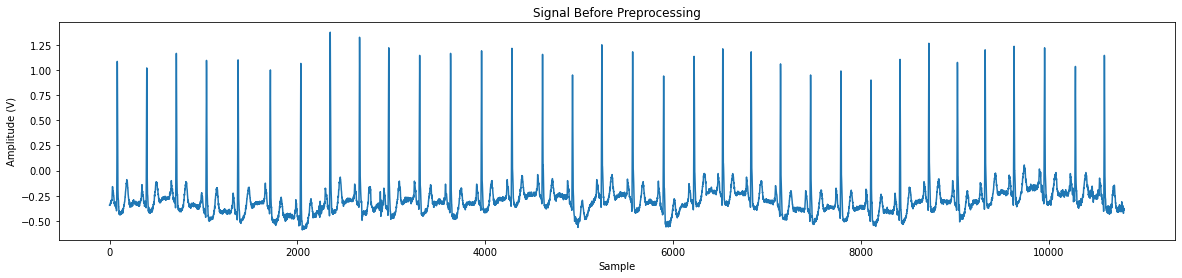

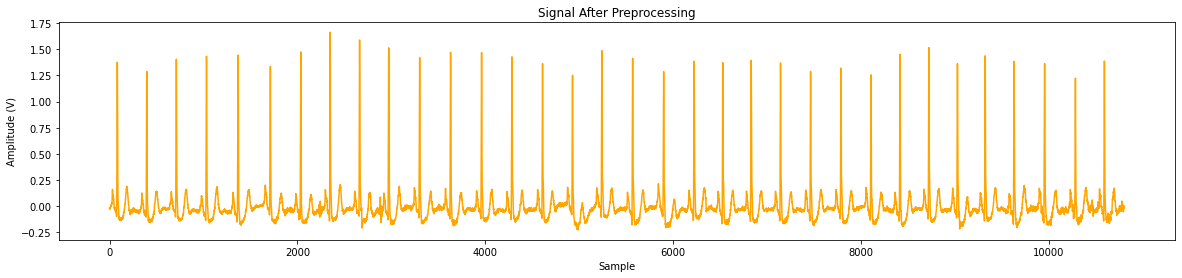

In [ ]:
import scipy.signal

sampling_rate = 360 # MIT-BIH ECG records are captured at 360Hz
raw_sig101 = wfdb.rdrecord('data/101', channels = [0], sampto = sampling_rate*30)

plt.plot(raw_sig101.p_signal[:,0])
plt.title('Signal Before Preprocessing')
plt.xlabel('Sample')
plt.ylabel('Amplitude (V)')

# Eliminate baseline wander
b, a = scipy.signal.butter(N=2, Wn=0.5, btype='highpass', analog=False, output='ba', fs=sampling_rate)
output1 = scipy.signal.filtfilt(b, a, raw_sig101.p_signal[:,0])

# Reduce Powerline Interference 
# Notch filter centered at 60 Hz
plt.figure()
b2, a2 = scipy.signal.iirnotch(w0=60.0, Q=30.0, fs=360.0)
output2 = scipy.signal.filtfilt(b2, a2, output1)
plt.plot(output2, color='orange')
plt.title('Signal After Preprocessing')
plt.xlabel('Sample')
plt.ylabel('Amplitude (V)')

In [ ]:
# Declare struct to hold important signal data
class Signal:
  def __init__(self, record, signal, r_peaks, labels):
    self.record = record # Record number
    self.signal = signal
    self.r_peaks = r_peaks
    self.labels = labels 

In [ ]:
"""
The data is provided by 
https://physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm
The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.
Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable
reference annotations for each beat (approximately 110,000 annotations in all) included with the database.
    Code		Description
    N		Normal beat (displayed as . by the PhysioBank ATM, LightWAVE, pschart, and psfd)
    L		Left bundle branch block beat
    R		Right bundle branch block beat
    B		Bundle branch block beat (unspecified)
    A		Atrial premature beat
    a		Aberrated atrial premature beat
    J		Nodal (junctional) premature beat
    S		Supraventricular premature or ectopic beat (atrial or nodal)
    V		Premature ventricular contraction
    r		R-on-T premature ventricular contraction
    F		Fusion of ventricular and normal beat
    e		Atrial escape beat
    j		Nodal (junctional) escape beat
    n		Supraventricular escape beat (atrial or nodal)
    E		Ventricular escape beat
    /		Paced beat
    f		Fusion of paced and normal beat
    Q		Unclassifiable beat
    ?		Beat not classified during learning
"""

# These are the classes that we wish to remove in the preprocessing stage
# since they do not refer to a particular beat type.
invalid_labels = ['|', # Isolated QRS-like artifact
                  '~', # Change in signal quality
                  '!', # Ventricular flutter wave
                  '+', # Rhythm change
                  '[', # Start of ventricular flutter/fibrillation
                  ']', # End of ventricular flutter/fibrillation
                  '"', # Comment annotation
                  'x'  # Non-conducted P-wave (blocked APC)
                  ]

# These are the beat types our program will be classifying
valid_classes = ['N', # Normal beat 
                 'L', #	Left bundle branch block beat
                 'R', # Right bundle branch block beat
                 'V', # Premature ventricular contraction
                 'A', # Atrial premature beat
                 '/', # Paced Beat
                 ]


In [ ]:
# Adapted from: https://github.com/JackAndCole/ECG-Classification-Using-CNN-and-CWT/blob/master/preprocessing.py
def process_record(record):
  """
    Input: An integer representing one of the ECG records from the MIT-BIH 
      database
    Output: A Signal object with the record number, signal data, r_peak data,
      and relevant annotations.
    Description: This function is responsible for the initial preprocessing of
      the ECG signals. It handles the denoising of the input signal by applying
      a butterworth filter (to eliminate baseline wander) and a notch filter 
      (to mitigate powerline interference). It also filters out any unwanted 
      annotations and adjusts the R-peak locations to ensure maximum accuracy.
  """
  raw_signal = wfdb.rdrecord(f'data/{record}', channels = [0]).p_signal[:,0] # MLII signal only
  annotation = wfdb.rdann(f'data/{record}', extension='atr')

  r_peaks = annotation.sample
  labels = np.array(annotation.symbol)

  # Eliminate baseline wander
  # Butterworth high-pass filter with an fc=0.5Hz
  b, a = scipy.signal.butter(N=2, Wn=0.5, btype='highpass', 
                             analog=False, output='ba', fs=sampling_rate)
  signal = scipy.signal.filtfilt(b, a, raw_signal)

  # Med filter
  # baseline = scipy.signal.medfilt(raw_signal, int(0.2 * sampling_rate - 1))
  # baseline = scipy.signal.medfilt(baseline, int(0.6 * sampling_rate - 1))
  # signal = raw_signal - baseline


  # Reduce Powerline Interference 
  # Notch filter centered at 60 Hz
  b, a = scipy.signal.iirnotch(w0=60.0, Q=30.0, fs=360.0)
  signal = scipy.signal.filtfilt(b, a, signal)

  # Remove unwanted beats
  indices = [i for (i, label) in enumerate(labels) if label not in invalid_labels]
  r_peaks, labels = r_peaks[indices], labels[indices]

  # Align the signals r_peaks to maximize accuracy
  aligned_peaks = []
  for r_peak in r_peaks:
    r_left = np.maximum(r_peak - int(.05 * sampling_rate), 0)
    r_right = np.minimum(r_peak + int(.05 * sampling_rate), len(signal))
    aligned_peaks.append(r_left + np.argmax(signal[r_left:r_right]))

  r_peaks = np.array(aligned_peaks, dtype="int")

  # Normalize signal amplitudes across all patients
  # Note: Could also try using sklearn.preprocessing.StandardScaler
  signal = signal / np.mean(signal[r_peaks])
  
  # Return an object with all relevant signal data & annotations
  return Signal(record, signal, r_peaks, labels)

In [ ]:
#@title Default title text
split = True #@param {type:"boolean"}

print(split)

True


In [ ]:
import pickle
import scipy.signal

train_ds = []
test_ds = []

if split == False:

  all_records = [100, 103, 105, 107, 111, 113, 117, 121, 123, 200, 202, 210, 
                212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234,
                101, 102, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 
                124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]

  for record_num in all_records:
    signal_data = process_record(record_num)
    train_ds.append(signal_data)

# Optional - Store data in gdrive
# save_path = "/content/drive/ECG_Classifier/preprocessed_mitdb.p"
# pickle.dump((train_ds, test_ds), open(save_path, "wb"))

In [ ]:
if split == True:
  train_records = [101, 102, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 
              124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]

  test_records = [100, 103, 105, 107, 111, 113, 117, 121, 123, 200, 202, 210, 
            212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
            
  for record_num in train_records:
    signal_data = process_record(record_num)
    train_ds.append(signal_data)

  for record_num in test_records:
    signal_data = process_record(record_num)
    test_ds.append(signal_data)


Beat Types: ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R'] 



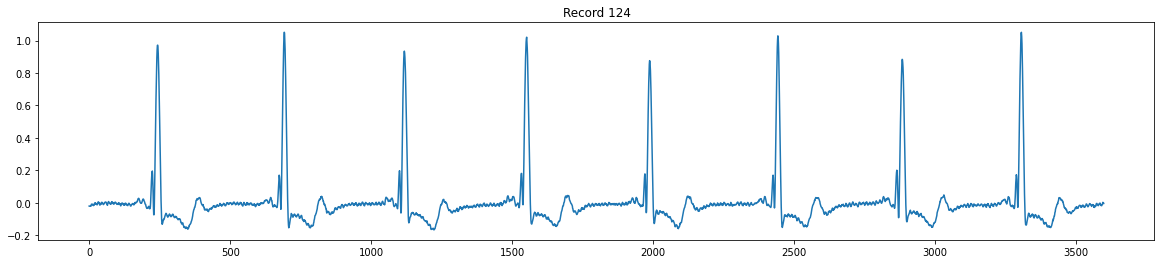

In [ ]:
# Visualize a waveform
# First 10 seconds of record '105'

view_signal = train_ds[12]
view_len = sampling_rate*10

plt.plot(range(view_len), view_signal.signal[0:view_len])
plt.title('Record {}'.format(view_signal.record))
print('Beat Types:', view_signal.labels[0:10], '\n')

In [ ]:
# Entire dataset beat distribution
print('Dataset Beat Distribution:')
total_sum = 0
for vc in valid_classes:
  sum = 0
  for sig_data in train_ds:
    for beat_label in sig_data.labels:
      if beat_label == vc:
        sum += 1
        total_sum += 1
  print(f'  {vc} - {sum}')
print(f'Total: {total_sum}')

Dataset Beat Distribution:
  N - 38201
  L - 3949
  R - 3783
  V - 3687
  A - 810
  / - 2028
Total: 52458


# **Feature Extraction**

*Note: RR ~ R-peak interval*

1.   Discrete Wavelet Transform (DWT)
2.   RR Intervals

Note: beats with RR not within a certain window most likely have segmentation errors and should be discarded. [1]

[1] https://github.com/mondejar/ecg-classification

check this out 
https://medium.com/@andrewtan_36013/electrocardiograms-qrs-detection-using-wavelet-analysis-a1070505efee



In [ ]:
# Helper functions for extracting features from DWT
def select_coeffs(coeffs):
  features = []
  for c in coeffs:
    features.append(np.mean(c))
    features.append(np.std(c))
    features.append(max(c))
    features.append(min(c))

  return np.array(features)

In [ ]:
import cv2
import pywt
import random
sampling_rate = 360

def extract_features(signal_data):
  """
    Input: Dict containing all information from a 
    Output: A tuple consisting of a 
    Description: This function 
  """
  r_peaks = signal_data.r_peaks
  labels = signal_data.labels
  signal = signal_data.signal
  leading_buf, lagging_buf = 90, 110
  valid_classes = ['N', 'L', 'R', 'V', 'A', '/']

  avg_RR = np.mean(np.diff(r_peaks)) # For removal of inter-patient variability
  wavelets, intervals_RR, classes = [], [], []
  global_RR = 0

  # Cycle through all of the beats in the signal
  # (Skip the first and last beat)
  for i in range(1, len(r_peaks) - 1):

    # Skip all invalid classes of beats
    if labels[i] not in valid_classes:
      continue
    
    # Normalize the surplus number of normal beats
    if labels[i] == 'N':
      if random.random() > 0.2:
        continue

    # ===== Discrete Wavelet Transform =====
    coeffs = pywt.wavedec(signal[r_peaks[i] - leading_buf : r_peaks[i] + lagging_buf], wavelet='db2', mode='perdiodization', level=3)[0]

    # ======= RR intervals =======
    pre_RR = r_peaks[i] - r_peaks[i - 1]
    post_RR = r_peaks[i + 1] - r_peaks[i] 
    local_RR = np.mean(np.diff((r_peaks[max(0,i-10):i + 1])))
    global_RR += pre_RR

    # Check for segmentation errors:
    if local_RR > (2 * sampling_rate) or local_RR < (0.15 < sampling_rate):
      continue

    wavelets.append(coeffs)
    classes.append(labels[i])
    intervals_RR.append([pre_RR - avg_RR, post_RR - avg_RR, local_RR - avg_RR])

  global_RR = global_RR/len(intervals_RR)
  for i in range(len(intervals_RR)):
    intervals_RR[i].append(global_RR)


  return (wavelets, intervals_RR, classes)

In [ ]:
from sklearn.model_selection import train_test_split  # Use for splitting training/validation datasets

x1_train, x1_test = [], []
x2_train, x2_test = [], []
y_train, y_test = [], []

# For training set
for signal_data in train_ds:
  wavelets, intervals_RR, classes = extract_features(signal_data)
  x1_train.append(wavelets)
  x2_train.append(intervals_RR)
  y_train.append(classes)

#  ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# For testing set
for signal_data in test_ds:
  wavelets, intervals_RR, classes = extract_features(signal_data)
  x1_test.append(wavelets)
  x2_test.append(intervals_RR)
  y_test.append(classes)

x1_test = np.concatenate(x1_test, axis=0).astype('float32')
x2_test = np.concatenate(x2_test, axis=0).astype('float32')
y_test = np.concatenate(y_test, axis=0)
y_test = np.array([valid_classes.index(k) for k in y_test]).astype('int64')
#  ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

x1_train = np.concatenate(x1_train, axis=0).astype('float32')
x2_train = np.concatenate(x2_train, axis=0).astype('float32')
y_train = np.concatenate(y_train, axis=0)
y_train = np.array([valid_classes.index(k) for k in y_train]).astype('int64')

# Validation set
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(x1_train, 
                                                                   x2_train, 
                                                                   y_train, 
                                                                   test_size=0.1, 
                                                                   shuffle=True, 
                                                                   random_state=42,
                                                                   stratify=y_train) 

print("Training Size: ", len(y_train))
print("Validation Size: ", len(y_val))
print("Testing Size: ", len(y_test))

ValueError: ignored

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the testing dataset
def sampling_strategy(n_samples):
    #target_classes_all = y.value_counts().index
    targets = range(len(valid_classes))
    sampling_strategy = {}
    for target in targets:
        sampling_strategy[target] = n_samples
    return sampling_strategy

undersample = RandomUnderSampler(sampling_strategy=sampling_strategy(500), 
                                 random_state = 42)

# x1_test, _ = undersample.fit_resample(x1_test, y_test)
# x2_test, y_test = undersample.fit_resample(x2_test, y_test)
x1_test, _ = undersample.fit_resample(x1_train, y_train)
x2_test, y_test = undersample.fit_resample(x2_train, y_train)

In [ ]:
train_size = len(y_train)
val_size = len(y_val)
test_size = len(y_test)

print(f'Size of Training Dataset: {train_size}')
print('Distribution:')
for vc in valid_classes:
  sum = 0
  for beat_label in y_train:
    if valid_classes[beat_label] == vc:
      sum += 1
  print(f'  {vc} - {sum}')

print(f'\nSize of Validation Dataset: {val_size}')
print('Distribution:')
for vc in valid_classes:
  sum = 0
  for beat_label in y_val:
    if valid_classes[beat_label] == vc:
      sum += 1
  print(f'  {vc} - {sum}')

print(f'\nSize of Testing Dataset: {test_size}')
# Training dataset distribution
print('Distribution:')
for vc in valid_classes:
  sum = 0
  for beat_label in y_test:
    if valid_classes[beat_label] == vc:
      sum += 1
  print(f'  {vc} - {sum}')

# **FFN**

Helpful References:

https://hub.packtpub.com/feedforward-networks-tensorflow/

https://gist.github.com/vinhkhuc/e53a70f9e5c3f55852b0

https://gist.github.com/Simsso/83fd5bf92c32d955e91ff4da4cfa48e9


**Keras Model**



In [ ]:
"""
  FNN Model
  Libraries used:
    -Tensorflow
    -Keras
  Description: the keras library makes it much easier to build a readable 
    neural network. Here we have constructed a model that takes in two
    feature sets, merges them together, then passes through 4 dense layers
    of decreasing sizes. Each dense layer uses the relu activation function and
    is followed by a dropout layer. The output layer uses a signmoid activation
    function.
"""

import tensorflow as tf
from keras.models import Model
from keras.layers import *

# Default learning rate of the Adam optimizer is 10e-4
learning_rate = 0.001
num_classes = len(valid_classes)

# Input Layer
input1 = Input(x1_train.shape[1])
input2 = Input(x2_train.shape[1])

# Merge Inputs
merged = Concatenate()([input1, input2])

# Dense Layer 1
dense1 = Dense(24, activation='relu')(merged)
dropout1 = Dropout(rate = 0.1)(dense1)

# Dense Layer 2
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(rate = 0.1)(dense2)

# Dense Layer 4
dense3 = Dense(24, activation='relu')(dropout2)
dropout3 = Dropout(rate = 0.1)(dense3)

# Output Layer
output = Dense(num_classes, activation='softmax')(dropout3)

model = Model(inputs=[input1, input2], outputs=output)
model.summary()

model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics = ['accuracy']
  )

# Print the models flow diagram
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# **Training**

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Custom metrics adapted from: https://www.sabinasz.net/unbalanced-classes-machine-learning/
# from keras import backend as K

# def sensitivity(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + K.epsilon())

# def specificity(y_true, y_pred):
#     true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
#     possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
#     return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
"""
  Description: Train the FNN using the training and validation datasets 
    defined earlier. Stores relevant training history in memory for later 
    analysis.

  Parameters:
    epochs = 500
    batch size = 100
"""
epochs = 250
batch_size = 256

history = model.fit([x1_train, x2_train], 
                    np.array(y_train), 
                    shuffle=True, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data = ([x1_val, x2_val], y_val))
                    

In [ ]:
# Plot training loss, validation loss
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(['Training Loss','Validation Loss'])
axs[0].set_title('Loss')
axs[0].set(xlabel='Epoch', ylabel='Loss')

# Plot training accuracy, validation accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].legend(['Training Accuracy','Validation Accuracy'])
axs[1].set_title('Accuracy')
axs[1].set(xlabel='Epoch', ylabel='Accuracy')

In [ ]:
# Plot training loss
plt.figure(0, figsize=(8, 8))
plt.plot(history.history['loss'])
plt.legend(['Training Loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.legend(['Training Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# **Evaluation**
**Determine important performance metrics of the model**

In [ ]:
# Print the accuracy of the Training, Validation, and Testing datasets
results = model.evaluate([x1_train, x2_train], y_train, verbose=0)
print('Training Accuracy: %.2f %%'%(results[1]*100))
results = model.evaluate([x1_val, x2_val], y_val, verbose=0)
print('Validation Accuracy: %.2f %%'%(results[1]*100))
results = model.evaluate([x1_test, x2_test], y_test, verbose=0)
print('Testing Accuracy: %.2f %%'%(results[1]*100))
print(results)

**Confusion Matrices**

In [ ]:
# Print the Confusion Matrix of the Training, Validation, and Testing datasets
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# === Training Dataset ===
y_train_actual = np.argmax(y_train, axis=1)  # Convert back from categorical array
y_train_pred = model.predict([x1_train, x2_train])
y_train_pred = np.argmax(y_train_pred, axis=1)
y_train_conf_matrix = confusion_matrix(y_train_actual, y_train_pred)
print('Training Confusion Matrix:\n')
print(y_train_conf_matrix)

# === Validation Dataset ===
y_val_actual = np.argmax(y_val, axis=1)  # Convert back from categorical array
y_val_pred = model.predict([x1_val, x2_val])
y_val_pred = np.argmax(y_val_pred, axis=1)
y_val_conf_matrix = confusion_matrix(y_val_actual, y_val_pred)
print('\n\nValidation Confusion Matrix:\n')
print(y_val_conf_matrix)

# === Testing Dataset ===
y_test_actual = np.argmax(y_test, axis=1)
y_test_pred = model.predict([x1_test, x2_test])
y_test_pred = np.argmax(y_test_pred, axis=1)
y_test_conf_matrix = confusion_matrix(y_test_actual, y_test_pred)
print('\n\nTesting Confusion Matrix:\n')
print(y_test_conf_matrix)

**Class Accuracy & Classification Report**

In [ ]:
"""
  Description: Class-by-class method for determining accuracy. The following 
    will compute the training, validation, and testing accuracy of each beat.
"""
# Training
print("Training Dataset Accuracies:")
for beat_type in range(len(valid_classes)):
  sum_true, sum_all = 0, 0
  for i in range(len(y_train_pred)):
    if y_train_actual[i] == beat_type:
      sum_all += 1 
      if y_train_pred[i] == y_train_actual[i]:
        sum_true += 1
  avg = sum_true / sum_all
  print(f' {valid_classes[beat_type]} - {avg:.4f}')

# Validation
print("\nValidation Dataset Accuracies:")
for beat_type in range(len(valid_classes)):
  sum_true, sum_all = 0, 0
  for i in range(len(y_val_pred)):
    if y_val_actual[i] == beat_type:
      sum_all += 1 
      if y_val_pred[i] == y_val_actual[i]:
        sum_true += 1
  avg = sum_true / sum_all
  print(f' {valid_classes[beat_type]} - {avg:.4f}')

# Testing
print("\nTesting Dataset Accuracies:")
for beat_type in range(len(valid_classes)):
  sum_true, sum_all = 0, 0
  for i in range(len(y_test_pred)):
    if y_test_actual[i] == beat_type:
      sum_all += 1 
      if y_test_pred[i] == y_test_actual[i]:
        sum_true += 1
  avg = sum_true / sum_all
  print(f' {valid_classes[beat_type]} - {avg:.4f}')


# def per_class_accuracy(y_preds,y_true,class_labels):
#     return [np.mean([
#         (y_true[pred_idx] == np.round(y_pred)) for pred_idx, y_pred in enumerate(y_preds) 
#       if y_true[pred_idx] == int(class_label)
#                     ]) for class_label in class_labels]

# def update_val_history():
#     [val_history[class_label].append(np.mean( np.asarray(temp_history).T[class_idx] )
#                              ) for class_idx, class_label in enumerate(class_labels)]

In [ ]:
"""
  Description: Class-by-class method for determining specificity. The following 
    will compute the training, validation, and testing specificity of each beat.
"""

# Training
print("Training Dataset Specificities:")
for beat_type in range(len(valid_classes)):
  row = y_train_conf_matrix[beat_type]
  col = y_train_conf_matrix[:,beat_type]
  FP = np.sum(row[:beat_type]) + np.sum(row[beat_type+1:])
  TN = len(y_train) - np.sum(col) - FP
  specificity = TN / (TN+FP)
  print(f' {valid_classes[beat_type]} - {specificity:.4f}')

# Validation
print("\nValidation Dataset Specificities:")
for beat_type in range(len(valid_classes)):
  row = y_val_conf_matrix[beat_type]
  col = y_val_conf_matrix[:,beat_type]
  FP = np.sum(row[:beat_type]) + np.sum(row[beat_type+1:])
  TN = len(y_val) - np.sum(col) - FP
  specificity = TN / (TN+FP)
  print(f' {valid_classes[beat_type]} - {specificity:.4f}')

# Testing
print("\nTesting Dataset Specificities:")
for beat_type in range(len(valid_classes)):
  row = y_test_conf_matrix[beat_type]
  col = y_test_conf_matrix[:,beat_type]
  FP = np.sum(row[:beat_type]) + np.sum(row[beat_type+1:])
  TN = len(y_test) - np.sum(col) - FP
  specificity = TN / (TN+FP)
  print(f' {valid_classes[beat_type]} - {specificity:.4f}')


In [ ]:
# Print a classification report for the Training, Validation, and Testing datasets
from sklearn.metrics import classification_report

# y_pred_train_bool = np.argmax(y_pred, axis=1)
print("\n\n\t\t\t===| Training |===\n")
print(classification_report(y_train_actual, y_train_pred, 
                            target_names=valid_classes, digits=4))

# y_val_pred_bool = np.argmax(y_pred, axis=1)
print("\n\n\t\t\t===| Validation |===\n")
print(classification_report(y_val_actual, y_val_pred, 
                            target_names=valid_classes, digits=4))

# y_test_pred_bool = np.argmax(y_pred, axis=1)
print("\n\n\t\t\t===| TESTING |===\n")
print(classification_report(y_test_actual, y_test_pred, 
                            target_names=valid_classes, digits=4))